In [1]:
using DataFrames, DataFramesMeta, JSON, Statistics
using StatsPlots
gr()

Plots.GRBackend()

In [2]:
data = []
for fname in readdir()
    name, ext = splitext(fname)
    if ext == ".json"
        fields = split(fname, '_')
        if fields[1] == "poisson"
            j = JSON.parsefile(fname; dicttype=Dict, inttype=Int64)
            push!(data, (fields, j, name))
        end
    end
end

In [6]:
df = DataFrame(
    name = String[],
    arrival_rate = Int[],
    vehicles = Int[],
    time_windows = Int[],
    locations = Int[],
    policy = String[],
    day = Int[],
    packages = Int[],
    avg_days_taken = Float64[],
    total_distance = Int[],
    total_time = Int[],
    deliveries = Int[],
    attempted_deliveries = Int[]
)
for v in data
    for record in v[2]
        push!(df, (
            v[3],
            parse(Int, v[1][2]),
            parse(Int, v[1][3]),
            parse(Int, v[1][4]),
            parse(Int, v[1][5]),
            v[1][6],
            record["day"],
            record["number_of_packages"],
            mean(record["delivered_packages"]["days_taken"]),
            sum(record["distances"]),
            sum(record["times"]),
            length(record["delivered_packages"]["days_taken"]),
            sum(record["deliveries_attempted"]),
        ))
    end
end
df

,name,arrival_rate,vehicles,time_windows,locations
,String,Int64,Int64,Int64,Int64
1,poisson_50_3_1_1_calling_policy,50,3,1,1
2,poisson_50_3_1_1_calling_policy,50,3,1,1
3,poisson_50_3_1_1_calling_policy,50,3,1,1
4,poisson_50_3_1_1_calling_policy,50,3,1,1
5,poisson_50_3_1_1_calling_policy,50,3,1,1
6,poisson_50_3_1_1_calling_policy,50,3,1,1
7,poisson_50_3_1_1_calling_policy,50,3,1,1
8,poisson_50_3_1_1_calling_policy,50,3,1,1
9,poisson_50_3_1_1_calling_policy,50,3,1,1


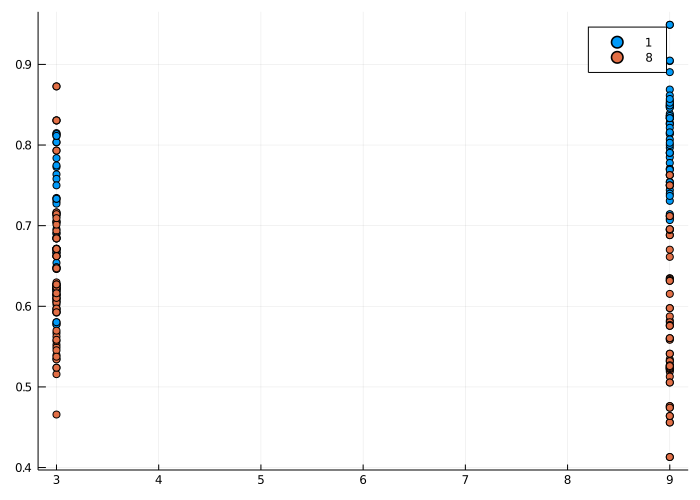

In [155]:
gr(size=(700,500))

@df (@linq df |> 
    where(:locations .== 2)
) scatter(
    :vehicles, :deliveries ./ :attempted_deliveries, group = :time_windows
)

Number of deliveries by locations


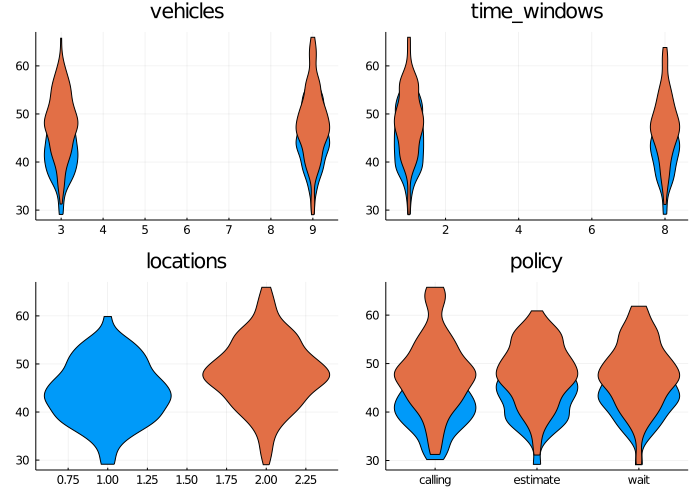

In [81]:
q = @linq df |>
    #where(:day .> 10) |>
    #by([:vehicles, :time_windows, :locations, :policy], y = mean(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q violin(:vehicles, :deliveries, group=:locations, title="vehicles", legend=nothing)
b = @df q violin(:time_windows, :deliveries, group=:locations, title="time_windows", legend=nothing)
c = @df q violin(:locations, :deliveries, group=:locations, title="locations", legend=nothing)
d = @df q violin(:policy, :deliveries,group=:locations, title="policy", legend=nothing)
println("Number of deliveries by locations")
plot(a,b,c,d)

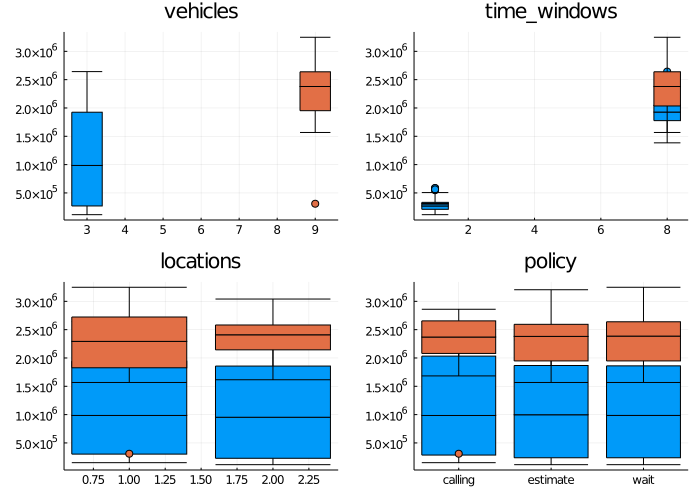

In [109]:
q = @linq df |>
    where(:total_time .> :vehicles .* 28800) |>
    #by([:vehicles, :time_windows, :locations, :policy], y = mean(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q boxplot(:vehicles, :total_time, group=:vehicles, title="vehicles", legend=nothing)
b = @df q boxplot(:time_windows, :total_time, group=:vehicles, title="time_windows", legend=nothing)
c = @df q boxplot(:locations, :total_time, group=:vehicles, title="locations", legend=nothing)
d = @df q boxplot(:policy, :total_time,group=:vehicles, title="policy", legend=nothing)
plot(a,b,c,d)

In [105]:
(df[:total_time] .< (df[:vehicles] .* 28800)) |> sum

119

In [102]:
28800 / 5

5760.0

In [110]:
using GLM

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1278


In [148]:
m = lm(@formula(attempted_deliveries ~ time_windows * vehicles), df)
m

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

attempted_deliveries ~ 1 + time_windows + vehicles + time_windows & vehicles

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)              91.5631     2.70288    33.88    <1e-99   86.2515   96.8747
time_windows             -1.92976    0.476407   -4.05    <1e-4    -2.86599  -0.993536
vehicles                 -3.21865    0.403169   -7.98    <1e-13   -4.01095  -2.42635
time_windows & vehicles   0.568651   0.0724113   7.85    <1e-13    0.42635   0.710952
─────────────────────────────────────────────────────────────────────────────────────